## Import

In [162]:
# Importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
import copy
import warnings
from google.colab import drive

In [163]:
pip install faker

In [164]:
import pandas as pd
import random
from faker import Faker
import datetime

random_seed = 23
random.seed(random_seed)  # Seed for random module
fake = Faker()
Faker.seed(random_seed)   # Seed for Faker library

# Create a list of school names and locations.
extended_school_names = [f'University {i}' for i in range(1, 201)]
extended_degrees = ["High School", 'Some College', 'Bachelors', 'Phd', 'Masters', 'Post-Doc']
extended_roles = [
    'Developer', 'Data Analyst', 'Business Analyst', 'Research Assistant',
    'Teaching Assistant', 'Software Engineer', 'Product Manager', 'System Analyst',
    'Database Administrator', 'Network Administrator', 'UX Designer', 'QA Analyst',
    'IT Manager', 'Technical Support Specialist', 'Data Scientist', 'Applications Developer',
    'Web Developer', 'Front-end Developer', 'Back-end Developer', 'Full-stack Developer'
]

# Ethnicity distribution according to given percentages
ethnicity_keys = [0, 1, 2, 3, 4]
# Adjusted ethnicity distribution to fit the new mapping
ethnicity_distribution = [0.4, 0.01, 0.05, 0.35, 0.19]  # Approximate distribution based on given numbers and mapping

# Gender distribution as specified: 75% M or F, 25% N/A with a higher proportion of M
gender_choices = ['M', 'F', 'N/A']
gender_distribution = [0.45, 0.3, 0.25]  # Adjusted for a higher proportion of Male candidates


def generate_dates(num_experiences):
    dates = []
    for i in range(num_experiences):
        # Generate a start date
        start_date = fake.date_between(start_date="-8y", end_date="-1y")

        # Ensure end date is between 30 days and 4 years after the start date
        end_date = fake.date_between(start_date=start_date + datetime.timedelta(days=30), end_date=start_date + datetime.timedelta(days=365*4))

        dates.extend([start_date, end_date])
    # Fill in 'N/A' for any unused date slots based on the number of experiences
    dates.extend([None] * (6 - len(dates)))  # Use None for unused date slots, which will later be converted to 'N/A' if necessary

    return dates

def generate_extended_data(num_entries=1000):
    data = pd.DataFrame({
        'Applicant ID': list(range(1, num_entries + 1)),
        'School Name': [random.choice(extended_school_names) for _ in range(num_entries)],
        'GPA': [round(random.uniform(2.8, 4.0), 2) for _ in range(num_entries)],
        'Degree': [random.choice(extended_degrees) for _ in range(num_entries)],
        'Location': [fake.city() for _ in range(num_entries)],  # Or use fake.zipcode() for zip codes
        'Gender': [random.choices(gender_choices, weights=gender_distribution, k=1)[0] for _ in range(num_entries)],
        'Veteran status': [random.choice(['1', '0', 'N/A']) for _ in range(num_entries)],
        'Work authorization': [random.choice(['1', '0']) for _ in range(num_entries)],
        'Disability': [random.choice(['1', '0', 'N/A']) for _ in range(num_entries)],
        'Ethnicity': [random.choices(ethnicity_keys, weights=ethnicity_distribution, k=1)[0] for _ in range(num_entries)],
    })

    roles = ['Role 1', 'Role 2', 'Role 3']
    date_columns = ['Start 1', 'End 1', 'Start 2', 'End 2', 'Start 3', 'End 3']
    for i in range(num_entries):
        num_experiences = random.choices([1, 2, 3], weights=[0.2, 0.3, 0.5])[0]
        dates = generate_dates(num_experiences)
        for j, date in enumerate(dates):
            if isinstance(date, datetime.date):
                data.at[i, date_columns[j]] = date.strftime('%m/%y')
            else:  # if the date is 'N/A'
                data.at[i, date_columns[j]] = 'N/A'
         # Fill roles and the remaining date columns with 'N/A' if not used
        for idx, role in enumerate(roles):
            data.at[i, role] = random.choice(extended_roles) if idx < num_experiences else 'N/A'
            if idx >= num_experiences:  # If no more roles, set the remaining dates to 'N/A'
                data.at[i, date_columns[idx * 2]] = 'N/A'  # Start date column
                data.at[i, date_columns[idx * 2 + 1]] = 'N/A'  # End date column


    return data


In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
# Generate the extended data
extended_data = generate_extended_data()

# Save the generated data to a CSV file
file_path = 'drive/MyDrive/fake_resume_scorer.csv'
extended_data.to_csv(file_path, index=False)

file_path

'drive/MyDrive/fake_resume_scorer.csv'

## Load Data + Evaluation Measurements

In [167]:
# Read the fake data WITH scores generated from resume_scorer
file_path = '/content/resume_scorer_final.csv'

# Load the data from the CSV file into a DataFrame
dataset = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(dataset.head())

   Applicant ID     School Name   GPA        Degree            Location  \
0             1  University 200  3.66   High School        Patricialand   
1             2   University 75  3.93   High School  New Kristopherfurt   
2             3   University 22  3.37           Phd        Davidborough   
3             4    University 5  3.74  Some College            Seanbury   
4             5  University 152  3.27      Post-Doc        Wintersville   

  Gender  Veteran status  Work authorization  Disability  Ethnicity  ...  \
0      F             1.0                   0         0.0          0  ...   
1      M             0.0                   0         1.0          0  ...   
2    NaN             0.0                   1         NaN          0  ...   
3      F             0.0                   0         1.0          4  ...   
4      F             1.0                   1         1.0          0  ...   

  Start 1  End 1                 Role 2 Start 2  End 2                Role 3  \
0   09/17  1

In [168]:
import numpy as np
from collections import OrderedDict

def compute_metrics(data_true, data_pred, protected_attribute, outcome, disp=True):
    """
    Compute various fairness metrics based on predicted and true labels.

    Args:
    - data_true (DataFrame): DataFrame containing true labels.
    - data_pred (DataFrame): DataFrame containing predicted labels.
    - protected_attribute (str): Name of the protected attribute column.
    - outcome (str): Name of the outcome column.
    - disp (bool): Whether to display the computed metrics. Default is True.

    Returns:
    - metrics (OrderedDict): Dictionary containing computed fairness metrics.
    """
    metrics = OrderedDict()

    y_true_privileged = data_true[data_true[protected_attribute] == 0][outcome] # white: ethnicity=0
    y_pred_privileged = data_pred[data_pred[protected_attribute] == 0][outcome]
    y_true_unprivileged = data_true[data_true[protected_attribute] != 0][outcome]
    y_pred_unprivileged = data_pred[data_pred[protected_attribute] != 0][outcome]

    tp_privileged_pred = np.sum((y_pred_privileged == 1)) / len(y_pred_privileged)
    tp_unprivileged_pred = np.sum((y_pred_unprivileged == 1)) / len(y_pred_unprivileged)

    y_true = data_true[outcome]
    y_pred = data_pred[outcome]
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    tp_privileged = np.sum((y_true_privileged == 1) & (y_pred_privileged == 1)) / np.sum(y_true_privileged == 1)
    tp_unprivileged = np.sum((y_true_unprivileged == 1) & (y_pred_unprivileged == 1)) / np.sum(y_true_unprivileged == 1)

    TP_majority = sum((y_true_privileged == 1) & (y_pred_privileged == 1))
    FN_majority = sum((y_true_privileged == 1) & (y_pred_privileged == 0))
    FP_majority = sum((y_true_privileged == 0) & (y_pred_privileged == 1))
    TN_majority = sum((y_true_privileged == 0) & (y_pred_privileged == 0))

    TP_minority = sum((y_true_unprivileged == 1) & (y_pred_unprivileged == 1))
    FN_minority = sum((y_true_unprivileged == 1) & (y_pred_unprivileged == 0))
    FP_minority = sum((y_true_unprivileged == 0) & (y_pred_unprivileged == 1))
    TN_minority = sum((y_true_unprivileged == 0) & (y_pred_unprivileged == 0))

    TPR_majority = TP_majority / (TP_majority + FN_majority)
    FPR_majority = FP_majority / (FP_majority + TN_majority)
    TPR_minority = TP_minority / (TP_minority + FN_minority)
    FPR_minority = FP_minority / (FP_minority + TN_minority)

    metrics['Balanced accuracy'] = (sensitivity + specificity) / 2
    metrics['Disparate impact'] = tp_unprivileged_pred / tp_privileged_pred
    metrics["Statistical parity difference"] = tp_privileged_pred - tp_unprivileged_pred
    metrics["Average odds difference"] = 0.5 * (abs(FPR_minority - FPR_majority) + abs(TPR_minority - TPR_majority))
    metrics["Equal opportunity difference"] = tp_privileged - tp_unprivileged

    if disp:
        for k, v in metrics.items():
            print(f"{k} = {v:.4f}")

    return metrics

## Preprocessing

In [169]:
dataset.head(20)

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,...,Start 1,End 1,Role 2,Start 2,End 2,Role 3,Start 3,End 3,Resume score,prediction
0,1,University 200,3.66,High School,Patricialand,F,1.0,0,0.0,0,...,09/17,11/18,NaN,NaN,NaN,NaN,NaN,NaN,9.51,0
1,2,University 75,3.93,High School,New Kristopherfurt,M,0.0,0,1.0,0,...,11/21,12/22,Network Administrator,04/17,02/21,Full-stack Developer,05/17,08/20,1.92,0
2,3,University 22,3.37,Phd,Davidborough,NaN,0.0,1,NaN,0,...,11/22,08/24,NaN,NaN,NaN,NaN,NaN,NaN,0.51,0
3,4,University 5,3.74,Some College,Seanbury,F,0.0,0,1.0,4,...,11/18,04/19,Data Scientist,12/18,01/22,Business Analyst,12/17,07/18,4.98,0
4,5,University 152,3.27,Post-Doc,Wintersville,F,1.0,1,1.0,0,...,02/21,04/24,Software Engineer,10/17,08/20,Developer,03/19,12/20,5.05,0
5,6,University 79,2.85,Bachelors,Lake Tyronetown,M,NaN,1,0.0,3,...,11/18,10/19,NaN,NaN,NaN,NaN,NaN,NaN,5.91,0
6,7,University 109,3.87,Bachelors,Howardton,NaN,0.0,1,NaN,0,...,03/23,08/25,NaN,NaN,NaN,NaN,NaN,NaN,3.92,0
7,8,University 98,3.31,Masters,Port Austin,F,1.0,1,NaN,4,...,11/20,06/24,Research Assistant,12/20,04/21,QA Analyst,11/17,05/18,3.14,0
8,9,University 136,3.48,Masters,Dianeborough,F,0.0,1,0.0,0,...,07/16,01/17,Web Developer,01/21,08/23,Research Assistant,09/18,06/22,4.97,0
9,10,University 92,3.89,High School,Arianastad,NaN,NaN,0,1.0,3,...,08/16,08/18,Full-stack Developer,01/23,09/26,NaN,NaN,NaN,2.37,0


In [170]:
# We add a 'work length' variable for the roles

from datetime import datetime

def parse_date(date):
    if pd.isnull(date):
        # If the date is missing, return today's date
        return pd.Timestamp.today()
    else:
        # Parse the date. Since the year is not included, we append the current year.
        return pd.to_datetime(date, format='%m/%y')


# Apply the parsing function to all 'Start' and 'End' date columns
date_cols = ['Start 1', 'End 1', 'Start 2', 'End 2', 'Start 3', 'End 3']
for col in date_cols:
    dataset[col] = dataset[col].apply(parse_date)

# Calculate the work length in days for each role, making sure to handle NaT values
for i in range(1, 4):
    dataset[f'Role {i} Length'] = (dataset[f'End {i}'] - dataset[f'Start {i}']).dt.days

In [171]:
# We transform the categorical variable Gender to be numerical
sex_code = {'M': 0, 'F': 1, np.nan: 2}

# We add the variable to the dataset
dataset['Gender'] = dataset['Gender'].map(sex_code)

# We transform the continuous variable score to be binary
dataset['resume_score_cat'] = dataset['Resume score'].apply(lambda x: 0 if x <= 5 else 1)

display(dataset.head(10))

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,...,End 2,Role 3,Start 3,End 3,Resume score,prediction,Role 1 Length,Role 2 Length,Role 3 Length,resume_score_cat
0,1,University 200,3.66,High School,Patricialand,1,1.0,0,0.0,0,...,2024-05-01 21:20:58.718812,NaN,2024-05-01 21:20:58.865481,2024-05-01 21:20:58.991945,9.51,0,426,0,0,1
1,2,University 75,3.93,High School,New Kristopherfurt,0,0.0,0,1.0,0,...,2021-02-01 00:00:00.000000,Full-stack Developer,2017-05-01 00:00:00.000000,2020-08-01 00:00:00.000000,1.92,0,395,1402,1188,0
2,3,University 22,3.37,Phd,Davidborough,2,0.0,1,NaN,0,...,2024-05-01 21:20:58.719086,NaN,2024-05-01 21:20:58.865858,2024-05-01 21:20:58.992323,0.51,0,639,0,0,0
3,4,University 5,3.74,Some College,Seanbury,1,0.0,0,1.0,4,...,2022-01-01 00:00:00.000000,Business Analyst,2017-12-01 00:00:00.000000,2018-07-01 00:00:00.000000,4.98,0,151,1127,212,0
4,5,University 152,3.27,Post-Doc,Wintersville,1,1.0,1,1.0,0,...,2020-08-01 00:00:00.000000,Developer,2019-03-01 00:00:00.000000,2020-12-01 00:00:00.000000,5.05,0,1155,1035,641,1
5,6,University 79,2.85,Bachelors,Lake Tyronetown,0,NaN,1,0.0,3,...,2024-05-01 21:20:58.719375,NaN,2024-05-01 21:20:58.866392,2024-05-01 21:20:58.992823,5.91,0,334,0,0,1
6,7,University 109,3.87,Bachelors,Howardton,2,0.0,1,NaN,0,...,2024-05-01 21:20:58.719382,NaN,2024-05-01 21:20:58.866404,2024-05-01 21:20:58.992835,3.92,0,884,0,0,0
7,8,University 98,3.31,Masters,Port Austin,1,1.0,1,NaN,4,...,2021-04-01 00:00:00.000000,QA Analyst,2017-11-01 00:00:00.000000,2018-05-01 00:00:00.000000,3.14,0,1308,121,181,0
8,9,University 136,3.48,Masters,Dianeborough,1,0.0,1,0.0,0,...,2023-08-01 00:00:00.000000,Research Assistant,2018-09-01 00:00:00.000000,2022-06-01 00:00:00.000000,4.97,0,184,942,1369,0
9,10,University 92,3.89,High School,Arianastad,2,NaN,0,1.0,3,...,2026-09-01 00:00:00.000000,NaN,2024-05-01 21:20:58.866927,2024-05-01 21:20:58.993233,2.37,0,730,1339,0,0


### Resume Scoring System
Run the following chunks ONLY for preprocessing when evaluating the resume scoring model

In [172]:
# Here we filter out the features we won't need, and define our outcome label, as well as the protected attribute

# features_to_keep = ['School Name', 'GPA', 'Degree', 'Location',
#                     'Gender',
#                     'Role 1', 'Role 2', 'Role 3',
#                     'Role 1 Length', 'Role 2 Length', 'Role 3 Length',
#                     'resume_score_cat']

# outcome_label = 'resume_score_cat'

# protected_attribute = 'Gender'
# nonprotected_attributes = features_to_keep.copy()
# nonprotected_attributes.remove(protected_attribute)
# nonprotected_attributes.remove(outcome_label)

# dataset = dataset[features_to_keep]

In [173]:
# Here we save categorical and numerical variables to their respective lists

# categorical_attributes = ['School Name', 'Degree', 'Location',
#                           'Role 1', 'Role 2', 'Role 3']

# numeric_attributes = ['GPA', 'Role 1 Length', 'Role 2 Length', 'Role 3 Length']

In [174]:
dataset.head(10)

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,...,End 2,Role 3,Start 3,End 3,Resume score,prediction,Role 1 Length,Role 2 Length,Role 3 Length,resume_score_cat
0,1,University 200,3.66,High School,Patricialand,1,1.0,0,0.0,0,...,2024-05-01 21:20:58.718812,NaN,2024-05-01 21:20:58.865481,2024-05-01 21:20:58.991945,9.51,0,426,0,0,1
1,2,University 75,3.93,High School,New Kristopherfurt,0,0.0,0,1.0,0,...,2021-02-01 00:00:00.000000,Full-stack Developer,2017-05-01 00:00:00.000000,2020-08-01 00:00:00.000000,1.92,0,395,1402,1188,0
2,3,University 22,3.37,Phd,Davidborough,2,0.0,1,NaN,0,...,2024-05-01 21:20:58.719086,NaN,2024-05-01 21:20:58.865858,2024-05-01 21:20:58.992323,0.51,0,639,0,0,0
3,4,University 5,3.74,Some College,Seanbury,1,0.0,0,1.0,4,...,2022-01-01 00:00:00.000000,Business Analyst,2017-12-01 00:00:00.000000,2018-07-01 00:00:00.000000,4.98,0,151,1127,212,0
4,5,University 152,3.27,Post-Doc,Wintersville,1,1.0,1,1.0,0,...,2020-08-01 00:00:00.000000,Developer,2019-03-01 00:00:00.000000,2020-12-01 00:00:00.000000,5.05,0,1155,1035,641,1
5,6,University 79,2.85,Bachelors,Lake Tyronetown,0,NaN,1,0.0,3,...,2024-05-01 21:20:58.719375,NaN,2024-05-01 21:20:58.866392,2024-05-01 21:20:58.992823,5.91,0,334,0,0,1
6,7,University 109,3.87,Bachelors,Howardton,2,0.0,1,NaN,0,...,2024-05-01 21:20:58.719382,NaN,2024-05-01 21:20:58.866404,2024-05-01 21:20:58.992835,3.92,0,884,0,0,0
7,8,University 98,3.31,Masters,Port Austin,1,1.0,1,NaN,4,...,2021-04-01 00:00:00.000000,QA Analyst,2017-11-01 00:00:00.000000,2018-05-01 00:00:00.000000,3.14,0,1308,121,181,0
8,9,University 136,3.48,Masters,Dianeborough,1,0.0,1,0.0,0,...,2023-08-01 00:00:00.000000,Research Assistant,2018-09-01 00:00:00.000000,2022-06-01 00:00:00.000000,4.97,0,184,942,1369,0
9,10,University 92,3.89,High School,Arianastad,2,NaN,0,1.0,3,...,2026-09-01 00:00:00.000000,NaN,2024-05-01 21:20:58.866927,2024-05-01 21:20:58.993233,2.37,0,730,1339,0,0


### Candidate Evaluation Model
Run the following chunks ONLY when evaluating the candidate evaluation model

In [175]:
# Here we filter out the features we won't need, and define our outcome label, as well as the protected attribute

features_to_keep = ['School Name', 'GPA', 'Degree', 'Location',
                    'Gender',
                    'Role 1', 'Role 2', 'Role 3',
                    'Role 1 Length', 'Role 2 Length', 'Role 3 Length',
                    'resume_score_cat', 'prediction']

outcome_label =  'prediction'

protected_attribute = 'Gender'
nonprotected_attributes = features_to_keep.copy()
nonprotected_attributes.remove(protected_attribute)
nonprotected_attributes.remove(outcome_label)

dataset = dataset[features_to_keep]

In [176]:
# Here we save categorical and numerical variables to their respective lists

categorical_attributes = ['School Name', 'Degree', 'Location',
                          'Role 1', 'Role 2', 'Role 3'
                          ,'resume_score_cat'
                          ]

numeric_attributes = ['GPA', 'Role 1 Length', 'Role 2 Length', 'Role 3 Length']

### Data Exploration

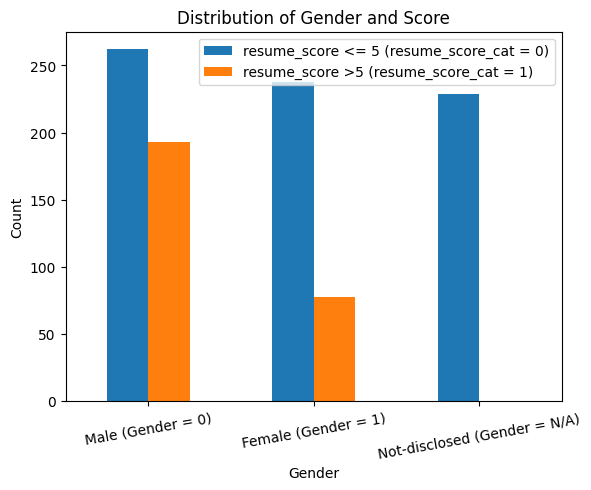

In [177]:
# a bar chart to show how the distribution of resume score higher and lower than 5 when we take Gender into account

gender_distrib = dataset[protected_attribute].value_counts()
joint_distrib = pd.crosstab(dataset[protected_attribute], dataset[outcome_label])
joint_distrib.plot(kind='bar')

# Adding labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender and Score')

tick_labels = ['Male (Gender = 0)', 'Female (Gender = 1)', 'Not-disclosed (Gender = N/A)']
plt.xticks(range(len(gender_distrib)), tick_labels, rotation=10)

# Show the plot
plt.legend(['resume_score <= 5 (resume_score_cat = 0)', 'resume_score >5 (resume_score_cat = 1)'])
plt.show()

##Model

In [178]:
from sklearn import linear_model as lm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [179]:
X_cols = features_to_keep.copy()

# Remove the outcome label from the list of features
X_cols.remove(outcome_label)

# Extract the features (independent variables) from the dataset
X = dataset[X_cols]

# Extract the outcome label (dependent variable) from the dataset
y = dataset[outcome_label]

# Extract numeric attributes from the independent variables
x_scale = X[numeric_attributes]

# Extract categorical attributes from the independent variables
x_encode = X[categorical_attributes]

# Scale the numeric variables
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_scale)

# One-hot encode the categorial variables
encoder = OneHotEncoder()
x_encoded = encoder.fit_transform(x_encode).toarray()

# Create DataFrames for scaled and one-hot encoded data
x_scaled_df = pd.DataFrame(x_scaled, columns=numeric_attributes)
x_encoded_df = pd.DataFrame(x_encoded, columns=encoder.get_feature_names_out(categorical_attributes))

# Concatenate the DataFrames back together
X_processed = pd.concat([x_scaled_df, x_encoded_df], axis=1)
X_processed[protected_attribute] = X[protected_attribute].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [180]:
# Define a custom logistic regression model using TensorFlow Keras

class LogisticRegression(tf.keras.Model):
    def __init__(self):
        super(LogisticRegression, self).__init__()

        self.layer1 = tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.layer2 = tf.keras.layers.Dense(units=16, activation='relu')  # Second hidden layer with 16 units

        # Define the output layer with 1 unit and sigmoid activation function
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')

    def call(self, x):
        # Pass the input through the first layer
        x = self.layer1(x)
        # Pass the output of the first layer through the second layer
        x = self.layer2(x)
        # Pass the output through the output layer
        output = self.output_layer(x)
        return output

In [181]:
model = LogisticRegression()
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
23/23 [==============================] - 2s 33ms/step - loss: 1.0837 - accuracy: 0.6375 - val_loss: 0.8378 - val_accuracy: 0.8750
Epoch 2/20
23/23 [==============================] - 0s 7ms/step - loss: 0.7589 - accuracy: 0.7181 - val_loss: 0.5939 - val_accuracy: 0.8750
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.6117 - accuracy: 0.7181 - val_loss: 0.4730 - val_accuracy: 0.8750
Epoch 4/20
23/23 [==============================] - 0s 12ms/step - loss: 0.5534 - accuracy: 0.7181 - val_loss: 0.4470 - val_accuracy: 0.8750
Epoch 5/20
23/23 [==============================] - 0s 8ms/step - loss: 0.5231 - accuracy: 0.7181 - val_loss: 0.4403 - val_accuracy: 0.8750
Epoch 6/20
23/23 [==============================] - 0s 12ms/step - loss: 0.4990 - accuracy: 0.7292 - val_loss: 0.4341 - val_accuracy: 0.8750
Epoch 7/20
23/23 [==============================] - 0s 12ms/step - loss: 0.4777 - accuracy: 0.7458 - val_loss: 0.4390 - val_accuracy: 0.8500
Epoch 8/20
23/2

In [182]:
# Calculate the loss and accuracy on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.7902 - accuracy: 0.6800


In [183]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

y_pred = predict_class(model.predict(X_test), 0.5)

7/7 [==============================] - 0s 3ms/step


In [184]:
# Concatenate the test features and true labels to create a DataFrame with true data
data_true = pd.concat([X_test, y_test], axis=1)

# Create a copy of the test features for predicted data
data_pred = X_test.copy()

# Add the predicted labels (y_pred) to the copied test features DataFrame
data_pred[outcome_label] = y_pred

# Baseline Fairness Statistics
compute_metrics(data_true=data_true, data_pred=data_pred,
                protected_attribute=protected_attribute, outcome=outcome_label)

Balanced accuracy = 0.5809
Disparate impact = 0.0828
Statistical parity difference = 0.4142
Average odds difference = 0.4013
Equal opportunity difference = 0.3752


OrderedDict([('Balanced accuracy', 0.5808644973288004),
             ('Disparate impact', 0.08277703604806408),
             ('Statistical parity difference', 0.414229725655713),
             ('Average odds difference', 0.4012925513987193),
             ('Equal opportunity difference', 0.3751937984496124)])

##Preprocessing Technique -- Disparate Impact Remover

In [185]:
def disparate_impact_remover(data, protected, features_to_transform, repair_fraction=1, num_buckets=20):
  """
  Remove disparate impact from specified features in the dataset following https://arxiv.org/pdf/1412.3756.pdf

  Args:
  - data (DataFrame): The input DataFrame containing the data.
  - protected (str): The name of the protected attribute column.
  - features_to_transform (list): List of feature names to transform.
  - repair_fraction (float): The fraction of the transformation to apply. Default is 1.

  Returns:
  - data_repaired (DataFrame): The repaired DataFrame with transformed features.
  """

  # Ensure the protected attribute is categorical
  data[protected] = data[protected].astype('category')
  data_repaired = data.copy()
  protected_groups = data[protected].cat.categories

  # Loop through each feature that needs to be transformed
  for feature in features_to_transform:
      quantiles = {}
      interval = np.linspace(0, 100, num_buckets)

      for subgroup in protected_groups:
        # TODO: Calculate quantile values for the subgroup
        # Hint: Use np.percentile() to get quantile values of the feature for the subgroup
        subgroup_data = data[data[protected] == subgroup]
        quantiles[subgroup] = np.percentile(subgroup_data[feature], interval)


      # TODO: Calculate the median of quantile values across subgroups
      quantiles_median = np.median(list(quantiles.values()), axis=0)

      # TODO: Apply the transformation for each subgroup using geometric repair
      # Hint: Use stats.percentileofscore() to map values of the feature to buckets using percentiles
      #       Use np.searchsorted() to find the indices of percentiles in the interval
      for subgroup in protected_groups:
        subgroup_data = data[data[protected] == subgroup][feature]
        subgroup_repaired = subgroup_data.copy()

        # Mapping values to percentile scores and then to buckets
        for i in subgroup_data.index:
            percentile_scores = stats.percentileofscore(subgroup_data, data.loc[i, feature], kind='weak')
            bucket_ind = np.searchsorted(interval, percentile_scores, side='right') - 1  # Find indices in interval

            # Calculate repaired values using the median quantiles
            repaired_values = ((1 - repair_fraction) * data.loc[i, feature] + repair_fraction * quantiles_median[bucket_ind])

            # TODO: Update the repaired values in data_repaired DataFrame
            data_repaired.loc[i, feature] = repaired_values

  return data_repaired

In [186]:
x_preproc = X[numeric_attributes]
x_preproc[protected_attribute] = X[protected_attribute].values

# Apply the Disparate Impact Remover to the preprocessed dataset
df = disparate_impact_remover(x_preproc, protected_attribute, numeric_attributes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Initialize a logistic regression model
model = LogisticRegression()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

model.fit(X_train_tensor, y_train_tensor, epochs=20, batch_size=32, validation_split=0.1)

y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.where(y_pred >= 0.5, 1, 0)

data_true = pd.concat([X_test, y_test], axis=1)
data_pred = X_test.copy()
data_pred[outcome_label] = y_pred

Epoch 1/20
23/23 [==============================] - 2s 31ms/step - loss: 38.8673 - accuracy: 0.6431 - val_loss: 9.4382 - val_accuracy: 0.7000
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 14.8209 - accuracy: 0.6306 - val_loss: 4.8964 - val_accuracy: 0.6875
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 5.6461 - accuracy: 0.6236 - val_loss: 2.0495 - val_accuracy: 0.8750
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 2.8431 - accuracy: 0.6667 - val_loss: 1.3804 - val_accuracy: 0.8250
Epoch 5/20
23/23 [==============================] - 0s 15ms/step - loss: 2.3722 - accuracy: 0.6361 - val_loss: 1.6978 - val_accuracy: 0.7875
Epoch 6/20
23/23 [==============================] - 0s 13ms/step - loss: 2.2969 - accuracy: 0.6347 - val_loss: 1.2368 - val_accuracy: 0.7125
Epoch 7/20
23/23 [==============================] - 0s 7ms/step - loss: 2.2890 - accuracy: 0.6375 - val_loss: 1.4316 - val_accuracy: 0.7875
Epoch 8/20
23/

In [187]:
compute_metrics(data_true=data_true, data_pred=data_pred,
                protected_attribute=protected_attribute, outcome=outcome_label)

Balanced accuracy = 0.5472
Disparate impact = 0.9984
Statistical parity difference = 0.0013
Average odds difference = 0.0786
Equal opportunity difference = 0.0837


OrderedDict([('Balanced accuracy', 0.5472316658572122),
             ('Disparate impact', 0.9983581712553675),
             ('Statistical parity difference', 0.0013064013666967966),
             ('Average odds difference', 0.07859959555106166),
             ('Equal opportunity difference', 0.08372093023255811)])

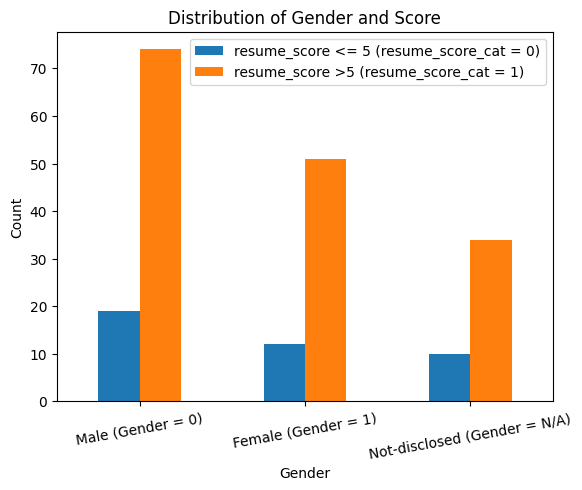

In [188]:
joint_distrib = pd.crosstab(data_pred[protected_attribute], data_pred[outcome_label])
joint_distrib.plot(kind='bar')

# Adding labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender and Score')

tick_labels = ['Male (Gender = 0)', 'Female (Gender = 1)', 'Not-disclosed (Gender = N/A)']
plt.xticks(range(len(gender_distrib)), tick_labels, rotation=10)

# Show the plot
plt.legend(['resume_score <= 5 (resume_score_cat = 0)', 'resume_score >5 (resume_score_cat = 1)'])
plt.show()

## In-processing Technique -- Prejudice Remover Regularizer

In [189]:
# Prepare the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)


# Indices of gender in training dataset
m_ind_train = X_train['Gender'] == 0
f_ind_train = X_train['Gender'] == 1
na_ind_train = X_train['Gender'] == 2

group_indices_train = [m_ind_train, f_ind_train, na_ind_train]

In [190]:
class PRLoss(tf.keras.regularizers.Regularizer):
    def __init__(self, group_indices, eta=1.0, **kwargs):
        super(PRLoss, self).__init__(**kwargs)
        self.eta = eta  # eta is the positive regularization parameter
        self.group_indices = group_indices  # A list of indices for each group

    def __call__(self, output):
        P_ys_group = []
        PI_group = []
        N_group = []

        total_samples = tf.cast(tf.shape(output)[0], dtype=tf.float32)
        P_y = tf.reduce_sum(output) / total_samples

        for indices in self.group_indices:
            indices_tensor = tf.where(indices)[:, 0]
            output_group = tf.gather(output, indices_tensor)
            N_group_tensor = tf.cast(tf.shape(output_group)[0], dtype=tf.float32)
            P_ys = tf.reduce_sum(output_group) / N_group_tensor

            P_ys_group.append(P_ys)
            N_group.append(N_group_tensor)

            P_sy = tf.math.log(P_ys / P_y)
            P_sny = tf.math.log((1 - P_ys) / (1 - P_y))

            PI_sy = output_group * P_sy
            PI_sny = (1 - output_group) * P_sny

            PI_group.append(tf.reduce_sum(PI_sy) + tf.reduce_sum(PI_sny))

        # Compute the total prejudice index by summing across all groups
        PI = self.eta * tf.reduce_sum(tf.stack(PI_group))

        return PI


In [191]:
class PRLR():
    def __init__(self, eta, epochs, lr):
        self.eta = eta
        self.epochs = epochs
        self.lr = lr


    def fit(self, x, y, group_indices):
        model = LogisticRegression()
        criterion = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM)

        PR = PRLoss(group_indices, eta=self.eta)

        # weight_decay is used for l2 regularization
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr, weight_decay=1e-5)

        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                # Forward pass
                output = model(x)

                # Calculate log loss
                logloss = criterion(y, output)

                # Calculate PI loss
                PIloss = tf.cast(PR(output),dtype='float32')

                # Calculate total loss
                loss = logloss + PIloss

            # Backward pass and optimization
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return model

In [192]:
from IPython.display import Markdown, display

def search_threshold(X_train, y_train, X_test, y_test, group_indices):
    ### In Logistic Regression, we can pick to threshold to decide above which value
    ### we will consider as positive label 1 and which value we will consider as 0.
    ### one way to balance between fairness and accuracy is to change a different
    ### threshold.
    ### Here you will iterate through 0.01 and 0.99 to search for the most balance
    ### threshold for classification
    display(Markdown("#### Predictions from original testing data by η coefficient on regularization"))

    data = dataset.copy()

    bal_acc_arr_orig = []
    disp_imp_arr_orig = []
    spd_arr_orig = []
    eod_arr_orig = []
    aaod_arr_orig = []
    eta_arr = np.linspace(0, 0.001, 5)

    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

    # Iterate over different eta values
    for eta in eta_arr:

        # Initialize and fit the PRLR model
        PR = PRLR(eta=eta, epochs=500, lr=0.01)
        model = PR.fit(X_train_tf, y_train_tf, group_indices)

        y_pred = model(X_test_tf)

        y_outcome = tf.cast(y_pred >= 0.5, tf.float32)
        y_outcome = tf.reshape(y_outcome, [tf.shape(y_outcome).numpy()[0]]).numpy()

        data_true = pd.concat([X_test, y_test], axis=1)
        data_pred = X_test.copy()
        data_pred[outcome_label] = y_outcome

        print(f"eta: {eta}")
        # Baseline Fairness Statistics
        metrics = compute_metrics(data_true=data_true, data_pred=data_pred,
                        protected_attribute=protected_attribute, outcome=outcome_label)
        print()

        bal_acc_arr_orig.append(metrics["Balanced accuracy"])
        disp_imp_arr_orig.append(metrics["Disparate impact"])
        spd_arr_orig.append(metrics["Statistical parity difference"])
        eod_arr_orig.append(metrics["Equal opportunity difference"])
        aaod_arr_orig.append(metrics["Average odds difference"])

   ### return an array of accuracy and di_impact with compute_metrics for the threshold
    return bal_acc_arr_orig, disp_imp_arr_orig, spd_arr_orig, eod_arr_orig, aaod_arr_orig

In [193]:
bal_acc_arr_orig, disp_imp_arr_orig, spd_arr_orig, eod_arr_orig, aaod_arr_orig = search_threshold(
    X_train, y_train, X_test, y_test, group_indices_train)

#### Predictions from original testing data by η coefficient on regularization

eta: 0.0
Balanced accuracy = 0.6115
Disparate impact = 0.1811
Statistical parity difference = 0.4227
Average odds difference = 0.4089
Equal opportunity difference = 0.4248

eta: 0.00025
Balanced accuracy = 0.5750
Disparate impact = 0.3311
Statistical parity difference = 0.3021
Average odds difference = 0.2524
Equal opportunity difference = 0.1752

eta: 0.0005
Balanced accuracy = 0.5539
Disparate impact = 0.4876
Statistical parity difference = 0.2259
Average odds difference = 0.1748
Equal opportunity difference = 0.0853

eta: 0.00075
Balanced accuracy = 0.5488
Disparate impact = 0.5126
Statistical parity difference = 0.2044
Average odds difference = 0.1827
Equal opportunity difference = 0.1519

eta: 0.001
Balanced accuracy = 0.5449
Disparate impact = 0.5136
Statistical parity difference = 0.2301
Average odds difference = 0.1901
Equal opportunity difference = 0.1085



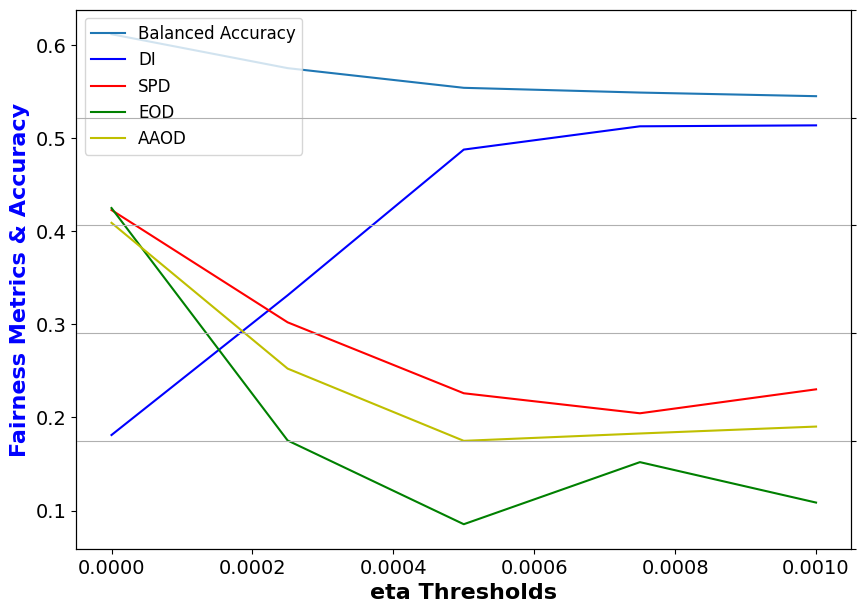

In [194]:
def plot_trade(eta_arr, bal_acc_arr_orig, disp_imp_arr_orig, spd_arr_orig, eod_arr_orig, aaod_arr_orig):
    fig, ax1 = plt.subplots(figsize=(10,7))

    # Plotting on the left y-axis
    ax1.set_xlabel('eta Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Fairness Metrics & Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)

    # Plotting on the left y-axis
    ax1.plot(eta_arr, bal_acc_arr_orig, label='Balanced Accuracy')
    ax1.plot(eta_arr, disp_imp_arr_orig, label='DI', color='b')
    ax1.plot(eta_arr, spd_arr_orig, label='SPD', color='r')
    ax1.plot(eta_arr, eod_arr_orig, label='EOD', color='g')
    ax1.plot(eta_arr, aaod_arr_orig, label='AAOD', color='y')

    # Adding legend
    ax1.legend(loc='upper left', fontsize=12)

    # Creating a second y-axis (ax2) on the right side
    ax2 = ax1.twinx()

    # Remove y labels on the right side
    ax2.set_yticklabels([])

    # Grid for the right y-axis
    ax2.grid(True)

    plt.show()

plot_trade(np.linspace(0, 0.001, 5), bal_acc_arr_orig, disp_imp_arr_orig, spd_arr_orig, eod_arr_orig, aaod_arr_orig)

## Post-processing Technique -- Reject Option based Classification (ROC)

In [195]:
def reject_option_classification(df, probability_col, sensitive_col,
                                 classification_col, theta, privileged_group=0):
    """
    Adjusts classifications based on probability thresholds to mitigate disparate impact.

    Parameters:
    - df : DataFrame
        Input DataFrame containing predictions and their probabilities.
    - probability_col : str
        Name of the column containing classification probabilities.
    - sensitive_col : str
        Name of the sensitive attribute column.
    - classification_col : str
        Name of the column containing classifications.
    - theta : float
        Threshold for classification probabilities (ROC margin value).
    - privileged_group : str, optional
        Label for the privileged group (ethnicity = white).

    Returns:
    - DataFrame
        DataFrame with adjusted classifications based on probability thresholds.
    """
    df_copy = df.copy()

    # TODO: Identify and update classifications for the privileged group
    privileged_indices = df_copy[(df_copy[sensitive_col] == privileged_group) &
                                 (df_copy[classification_col] == 1) &
                                 (df_copy[probability_col] > 0.5) &
                                 (df_copy[probability_col] <= 0.5 + theta)].index
    df_copy.loc[privileged_indices, classification_col] = 0

    # TODO: Identify and update classifications for the unprivileged group
    unprivileged_indices = df_copy[(df_copy[sensitive_col] != privileged_group) &
                                 (df_copy[classification_col] == 0) &
                                 (df_copy[probability_col] > 0.5) &
                                 (df_copy[probability_col] <= 0.5 + theta)].index
    df_copy.loc[unprivileged_indices, classification_col] = 1

    # TODO: Remove privileged and unprivileged instances from the original data frame
    original_df = df.drop(privileged_indices.union(unprivileged_indices))

    # TODO: Drop the probability column as it's no longer needed
    df_copy = df_copy.drop(columns=[probability_col])

    # TODO: Concatenate the updated privileged and unprivileged instances with the original data frame
    updated_df = pd.concat([original_df, df_copy.loc[privileged_indices.union(unprivileged_indices)]])

    return updated_df


In [196]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
23/23 [==============================] - 1s 13ms/step - loss: 1.0453 - accuracy: 0.7083 - val_loss: 0.7482 - val_accuracy: 0.8750
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 0.7154 - accuracy: 0.7181 - val_loss: 0.5133 - val_accuracy: 0.8750
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5848 - accuracy: 0.7181 - val_loss: 0.4642 - val_accuracy: 0.8875
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.5224 - accuracy: 0.7542 - val_loss: 0.4539 - val_accuracy: 0.8500
Epoch 5/20
23/23 [==============================] - 0s 5ms/step - loss: 0.4776 - accuracy: 0.7806 - val_loss: 0.4511 - val_accuracy: 0.8375
Epoch 6/20
23/23 [==============================] - 0s 5ms/step - loss: 0.4419 - accuracy: 0.8208 - val_loss: 0.4624 - val_accuracy: 0.8250
Epoch 7/20
23/23 [==============================] - 0s 5ms/step - loss: 0.4095 - accuracy: 0.8583 - val_loss: 0.4644 - val_accuracy: 0.8250
Epoch 8/20
23/23 [=

In [197]:
warnings.filterwarnings("ignore")
class_probabilities = model.predict(X_test)
data_pred[outcome_label] = np.where(class_probabilities >= 0.5, 1, 0)
data_pred['probability'] = np.maximum(class_probabilities, 1-class_probabilities)

7/7 [==============================] - 0s 3ms/step


In [198]:
post_processed = reject_option_classification(data_pred, 'probability', protected_attribute, outcome_label, 0.2)
compute_metrics(data_true=data_true, data_pred=post_processed,
                protected_attribute=protected_attribute, outcome=outcome_label)

Balanced accuracy = 0.5299
Disparate impact = 0.2069
Statistical parity difference = 0.1791
Average odds difference = 0.1696
Equal opportunity difference = 0.1426


OrderedDict([('Balanced accuracy', 0.5298688683827101),
             ('Disparate impact', 0.20694259012016022),
             ('Statistical parity difference', 0.1790774796502864),
             ('Average odds difference', 0.1695786990225817),
             ('Equal opportunity difference', 0.14263565891472868)])

In [199]:
metrics = {key: [] for key in ['Balanced accuracy', 'Disparate impact', 'Statistical parity difference', 'Average odds difference', 'Equal opportunity difference']}

for level in np.linspace(0., 0.4, 20):
    post_processed = reject_option_classification(data_pred, 'probability', protected_attribute, outcome_label, level)

    res = compute_metrics(data_true=data_true, data_pred=post_processed,
                protected_attribute=protected_attribute, outcome=outcome_label, disp=False)

    for metric in res:
        metrics[metric].append(res[metric])

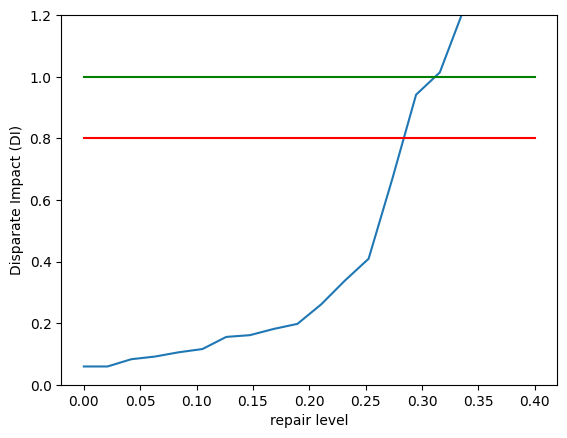

In [200]:
plt.plot(np.linspace(0., 0.4, 20), metrics['Disparate impact'])
plt.plot([0, 0.4], [1, 1], 'g')
plt.plot([0, 0.4], [0.8, 0.8], 'r')
plt.ylim([0, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

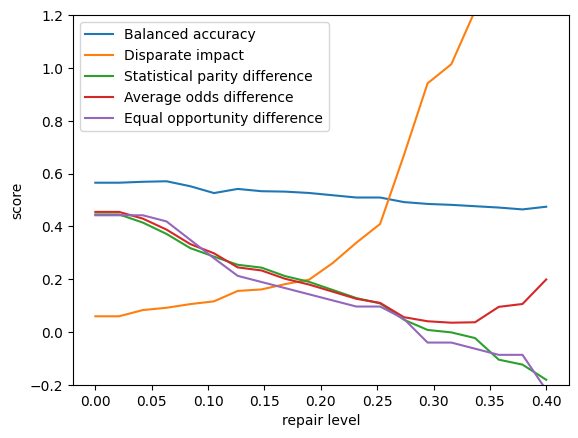

In [201]:
for metric in metrics:
  plt.plot(np.linspace(0., 0.4, 20), metrics[metric])
plt.legend(metrics.keys())
plt.ylim([-0.2, 1.2])
plt.ylabel('score')
plt.xlabel('repair level')
plt.show()